# Discontinuity Analysis

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
sns.set(style="whitegrid")

# Show data without scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Kernel weighted RD

In [78]:
class Kernels:
    def __init__(self):
        pass
        

    # Triangular kernel
    def triangular_kernel(R, c, h):
        indicator = (np.abs(R - c) <= h).astype(float)
        return indicator * (1 - np.abs(R - c) / h)
    
    # Epanechnikov kernel
    def epanechnikov_kernel(R, c, h):
        indicator = (np.abs(R - c) <= h).astype(float)
        return indicator * (3/4) * (1 - ((R - c) / h) ** 2)
    

# Plotting Dataframe Generation

In [79]:
# Generate Plotting Dataframe
def generate_plotting_df(data):
    cutoff = 0
    bandwidth = 10000
    bin_size = 20

    # Filter out the outliers
    plotting_df = data.copy()
    plotting_df = plotting_df[(plotting_df['dollars_to_goal'] <= bandwidth) & (plotting_df['dollars_to_goal'] >= -bandwidth)]

    # Split data into left and right of the cutoff
    left_df = plotting_df[(plotting_df['state'] == 'failed') & (plotting_df['dollars_to_goal'] < cutoff)]
    right_df = plotting_df[(plotting_df['state'] == 'successful') & (plotting_df['dollars_to_goal'] >= cutoff)]

    # Bin each subset separately
    left_df['dollars_to_goal_binned'] = pd.cut(left_df['dollars_to_goal'], bins=bin_size)
    right_df['dollars_to_goal_binned'] = pd.cut(right_df['dollars_to_goal'], bins=bin_size)

    # Aggregate the binned data for each subset
    left_binned_data = left_df.groupby('dollars_to_goal_binned', observed=False).agg({
        'success_next': 'mean',
        'goal': 'mean',
        'backers_count': 'mean',
        'staff_pick': 'mean',
        'prelaunch_activated': 'mean',
        'dollars_to_goal': 'size'  # Counts the number of observations in each bin
    }).reset_index().rename(columns={'dollars_to_goal': 'n_obs'})
    right_binned_data = right_df.groupby('dollars_to_goal_binned', observed=False).agg({
        'success_next': 'mean',
        'goal': 'mean',
        'backers_count': 'mean',
        'staff_pick': 'mean',
        'prelaunch_activated': 'mean',
        'dollars_to_goal': 'size'  # Counts the number of observations in each bin
    }).reset_index().rename(columns={'dollars_to_goal': 'n_obs'})

    # Add a midpoint for each bin for both left and right data
    left_binned_data['dollars_to_goal'] = left_binned_data['dollars_to_goal_binned'].apply(lambda interval: interval.mid)
    right_binned_data['dollars_to_goal'] = right_binned_data['dollars_to_goal_binned'].apply(lambda interval: interval.mid)

    # Combine the binned data for both sides of the cutoff
    plotting_df = pd.concat([left_binned_data, right_binned_data], ignore_index=True)
    return plotting_df

# Load the Data

In [80]:
# Load the data
df = pd.read_json('../data/creator_first_project.json', lines = True)
df.shape

(328652, 148)

Define Running Variable

In [81]:
# Calculate the dollars to goal
df['dollars_to_goal'] = df['usd_pledged']  - df['usd_goal']

# Key Statistics

In [82]:
# Check success next statistics
df[['usd_goal', 'usd_pledged', 'dollars_to_goal', 'staff_pick', 'backers_count']].describe()

,usd_goal,usd_pledged,dollars_to_goal,staff_pick,backers_count
count,328652.000,328652.000,328652.000,321019.000,328652.000
mean,39749.071,12231.960,-27517.111,0.115,129.538
std,1049282.913,97368.424,1053242.408,0.319,936.501
min,0.511,0.000,-152350076.000,0.000,0.000
25%,2000.000,73.214,-7000.000,0.000,3.000
50%,5000.000,1228.000,-50.000,0.000,21.000
75%,15000.000,6055.000,620.993,0.000,77.000
max,152350076.000,13285226.360,13235226.360,1.000,219382.000


In [83]:
# Replace nas with 0
filled_df = df.copy()
filled_df['success_next'] = filled_df['success_next'].fillna(0)

# Generate Plotting Dataframe

In [84]:
plotting_df = generate_plotting_df(df)

C:\Users\d0tam\AppData\Local\Temp\ipykernel_58188\1573815772.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left_df['dollars_to_goal_binned'] = pd.cut(left_df['dollars_to_goal'], bins=bin_size)
C:\Users\d0tam\AppData\Local\Temp\ipykernel_58188\1573815772.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  right_df['dollars_to_goal_binned'] = pd.cut(right_df['dollars_to_goal'], bins=bin_size)


In [85]:
# Describe success_next
plotting_df


,dollars_to_goal_binned,success_next,goal,backers_count,staff_pick,prelaunch_activated,n_obs,dollars_to_goal
0,"(-10010.0, -9500.0]",0.184,12736.141,5.683,0.011,0.080,6489,-9755.000
1,"(-9500.0, -9000.001]",0.500,19623.093,18.209,0.046,0.156,1543,-9250.001
2,"(-9000.001, -8500.001]",0.450,16377.204,19.113,0.047,0.121,1663,-8750.001
3,"(-8500.001, -8000.002]",0.429,19985.869,20.150,0.049,0.130,1431,-8250.002
4,"(-8000.002, -7500.002]",0.332,12199.663,12.762,0.029,0.103,2673,-7750.002
5,"(-7500.002, -7000.003]",0.321,14694.770,13.611,0.043,0.098,2350,-7250.003
6,"(-7000.003, -6500.003]",0.354,11549.844,14.811,0.038,0.117,2479,-6750.003
7,"(-6500.003, -6000.004]",0.418,13142.336,15.791,0.036,0.116,2087,-6250.003
8,"(-6000.004, -5500.004]",0.369,10746.275,12.472,0.038,0.103,3012,-5750.004
9,"(-5500.004, -5000.005]",0.411,12053.622,15.408,0.047,0.117,2398,-5250.005


## Plot Next Project Success by Dollars to Goal

Text(0.5, 1.0, 'Probability of Next Project Success by Dollars to Goal')

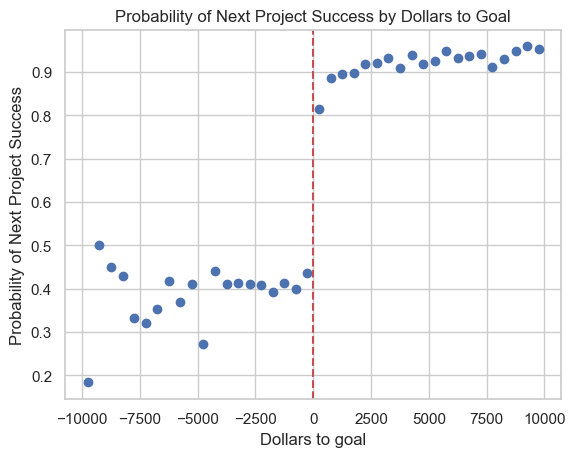

In [86]:
cutoff = 0
plt.figure()
plt.plot(plotting_df['dollars_to_goal'], plotting_df['success_next'], 'o')
plt.axvline(x=cutoff, color='r', linestyle='--')
plt.xlabel('Dollars to goal')
plt.ylabel('Probability of Next Project Success')
plt.title('Probability of Next Project Success by Dollars to Goal')

# Effect of First Kickstarter on Next Kickstarter

## Regression Variables

In [87]:
# Create threshold Variable
df = df.assign(threshold = (df['dollars_to_goal'] > 0).astype(int)).sort_values('dollars_to_goal').reset_index(drop=True)

# Calculate the dollars to goal times threshold
df['dollars_to_goal*threshold'] = df['dollars_to_goal'] * df['threshold']

# Quadtratic term
df['dollars_to_goal_2'] = df['dollars_to_goal'] ** 2
df['dollars_to_goal_2*threshold'] = df['dollars_to_goal_2'] * df['threshold']

## Naive Model

Drop NAs from Main Dataframe

In [88]:
# Create df with no NAs in success_next
ml_df = df.dropna(subset=['success_next'])

In [89]:
from sklearn.linear_model import LogisticRegression

# Fit the model
X = ml_df[['dollars_to_goal', 'threshold', 'dollars_to_goal*threshold']]
y = ml_df['success_next']

model = LogisticRegression(fit_intercept=True, verbose = 1).fit(X,y)

# Print param names and coefficients
coef_dict = {}
for coef, feat in zip(model.coef_[0,:], model.feature_names_in_):
    coef_dict[feat] = "{:.10f}".format(coef)

coef_dict

{'dollars_to_goal': '0.0000015681',
 'threshold': '2.6021127538',
 'dollars_to_goal*threshold': '0.0000078132'}

In [90]:
table_model = smf.glm('success_next ~ dollars_to_goal + threshold + dollars_to_goal*threshold', 
                family = sm.families.Binomial(), 
                data = df).fit()

table_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           success_next   No. Observations:                45300
Model:                            GLM   Df Residuals:                    45296
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20330.
Date:                Thu, 05 Dec 2024   Deviance:                       40659.
Time:                        13:17:55   Pearson chi2:                 7.36e+14
No. Iterations:                     9   Pseudo R-squ. (CS):             0.2847
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -0.6164      0.017    -35.279      0.000      -0.651      -0.582
dollars_to_goal            1.565e-06   2.27e-07      6.900      0.000    1.12e-06    2.01e-06
threshold                     2.6039      0.026     98.569      0.000       2.552       2.656
dollars_to_goal:threshold    7.8e-06   9.84e-07      7.928      0.000    5.87e-06    9.73e-06
=============================================================================================
"""

In [91]:
# Get the percent change in probability from log odds
print(f"Threshold Parameter: {model.coef_[0,1]:.5f}")
probability = np.exp(model.coef_[0,1]) - 1
print(f"Change in probability of success: {probability:.2f}%")

Threshold Parameter: 2.60211
Change in probability of success: 12.49%


In [92]:
plotting_df = generate_plotting_df(df)

C:\Users\d0tam\AppData\Local\Temp\ipykernel_58188\1573815772.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left_df['dollars_to_goal_binned'] = pd.cut(left_df['dollars_to_goal'], bins=bin_size)
C:\Users\d0tam\AppData\Local\Temp\ipykernel_58188\1573815772.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  right_df['dollars_to_goal_binned'] = pd.cut(right_df['dollars_to_goal'], bins=bin_size)


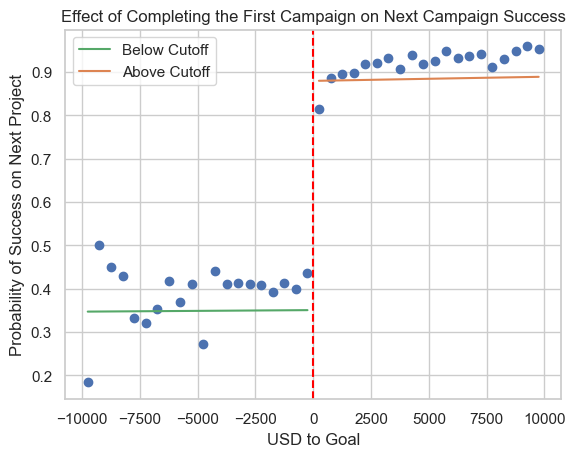

In [93]:
# Remove outliers
plt.figure()
plt.scatter(plotting_df['dollars_to_goal'], plotting_df['success_next'], color = "C0")
#ax = plotting_df.plot.scatter(x = 'dollars_to_goal', y = 'success_next', color = "C0")

# Create threshold and Interaction Variable
cutoff = 0
plotting_df['threshold'] = 0
plotting_df.loc[plotting_df['dollars_to_goal'] > cutoff, 'threshold'] = 1

# Convert threshold to int
plotting_df['threshold'] = plotting_df['threshold'].astype(int)
plotting_df['dollars_to_goal*threshold'] = plotting_df['dollars_to_goal'] * plotting_df['threshold']

exog_dict = plotting_df[['dollars_to_goal', 'threshold', 'dollars_to_goal*threshold']]
plotting_df['predictions'] = model.predict_proba(exog_dict)[:,1]
left_plotting_df = plotting_df[plotting_df['dollars_to_goal'] < cutoff]
right_plotting_df = plotting_df[plotting_df['dollars_to_goal'] >= cutoff]
plt.plot(left_plotting_df['dollars_to_goal'], left_plotting_df['predictions'], color = 'C2', label = 'Below Cutoff')
plt.plot(right_plotting_df['dollars_to_goal'], right_plotting_df['predictions'], color = 'C1', label = 'Above Cutoff')
plt.legend()
plt.axvline(x = 1, color = 'red', linestyle = '--')
plt.ylabel('Probability of Success on Next Project')
plt.xlabel('USD to Goal')
plt.title('Effect of Completing the First Campaign on Next Campaign Success')

plt.savefig('../images/next_kickstarter/effect_of_completing_the_first_campaign_on_next_campaign_success.png')
plt.show()


## Including Quitters

In [94]:
plotting_df = generate_plotting_df(filled_df)

C:\Users\d0tam\AppData\Local\Temp\ipykernel_58188\1573815772.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left_df['dollars_to_goal_binned'] = pd.cut(left_df['dollars_to_goal'], bins=bin_size)
C:\Users\d0tam\AppData\Local\Temp\ipykernel_58188\1573815772.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  right_df['dollars_to_goal_binned'] = pd.cut(right_df['dollars_to_goal'], bins=bin_size)


In [95]:
# Create threshold Variable
filled_df = filled_df.assign(threshold = (filled_df['dollars_to_goal'] > 0).astype(int)).sort_values('dollars_to_goal').reset_index(drop=True)
# Calculate the dollars to goal times threshold
filled_df['dollars_to_goal*threshold'] = filled_df['dollars_to_goal'] * filled_df['threshold']

In [96]:
X = filled_df[['dollars_to_goal', 'threshold', 'dollars_to_goal*threshold']]
y = filled_df['success_next']

model = LogisticRegression(fit_intercept=True, verbose = 1).fit(X,y)

# Print param names and coefficients
coef_dict = {}
for coef, feat in zip(model.coef_[0,:], model.feature_names_in_):
    coef_dict[feat] = "{:.10f}".format(coef)

coef_dict

{'dollars_to_goal': '0.0000013473',
 'threshold': '1.7017218891',
 'dollars_to_goal*threshold': '-0.0000005472'}

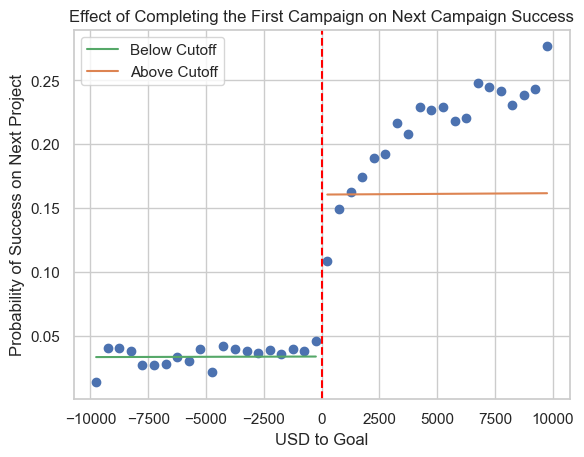

In [97]:
# Remove outliers
plt.figure()
plt.scatter(plotting_df['dollars_to_goal'], plotting_df['success_next'], color = "C0")
#ax = plotting_df.plot.scatter(x = 'dollars_to_goal', y = 'success_next', color = "C0")

# Create threshold and Interaction Variable
cutoff = 0
plotting_df['threshold'] = 0
plotting_df.loc[plotting_df['dollars_to_goal'] > cutoff, 'threshold'] = 1

# Convert threshold to int
plotting_df['threshold'] = plotting_df['threshold'].astype(int)
plotting_df['dollars_to_goal*threshold'] = plotting_df['dollars_to_goal'] * plotting_df['threshold']

exog_dict = plotting_df[['dollars_to_goal', 'threshold', 'dollars_to_goal*threshold']]
plotting_df['predictions'] = model.predict_proba(exog_dict)[:,1]
left_plotting_df = plotting_df[plotting_df['dollars_to_goal'] < cutoff]
right_plotting_df = plotting_df[plotting_df['dollars_to_goal'] >= cutoff]
plt.plot(left_plotting_df['dollars_to_goal'], left_plotting_df['predictions'], color = 'C2', label = 'Below Cutoff')
plt.plot(right_plotting_df['dollars_to_goal'], right_plotting_df['predictions'], color = 'C1', label = 'Above Cutoff')
plt.legend()
plt.axvline(x = 1, color = 'red', linestyle = '--')
plt.ylabel('Probability of Success on Next Project')
plt.xlabel('USD to Goal')
plt.title('Effect of Completing the First Campaign on Next Campaign Success')

plt.savefig('../images/next_kickstarter/effect_of_completing_the_first_campaign_on_next_campaign_success.png')
plt.show()


## RD with Kernel

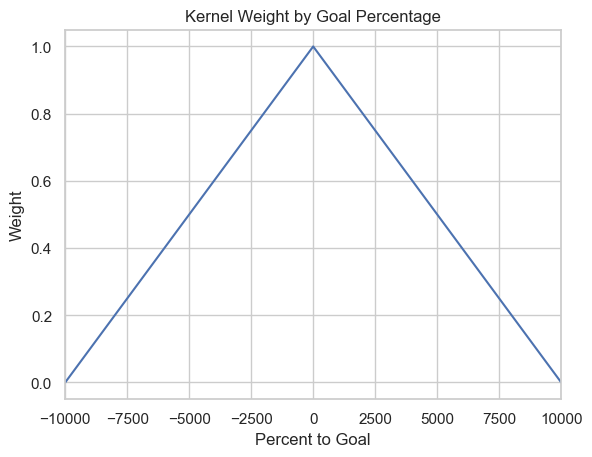

In [98]:
bandwidth = 10000
plt.plot(sorted(ml_df["dollars_to_goal"]), Kernels.triangular_kernel(ml_df["dollars_to_goal"], c=cutoff, h=bandwidth), label="Triangular Kernel")
plt.xlabel("Percent to Goal")
plt.ylabel("Weight")
plt.xlim(-bandwidth, bandwidth)
plt.title("Kernel Weight by Goal Percentage");

In [99]:
X, y = ml_df[['dollars_to_goal', 'threshold', 'dollars_to_goal*threshold']], ml_df['success_next']
cutoff = 0
bandwidth = 10000
model = LogisticRegression(fit_intercept=True, verbose = 1).fit(X,y, sample_weight=Kernels.triangular_kernel(ml_df['dollars_to_goal'], c=cutoff, h=bandwidth))

# Print param names and coefficients
coef_dict = {}
for coef, feat in zip(model.coef_[0,:], model.feature_names_in_):
    coef_dict[feat] = "{:.10f}".format(coef)

coef_dict

{'dollars_to_goal': '0.0000833653',
 'threshold': '1.7300048281',
 'dollars_to_goal*threshold': '0.0002019925'}

In [100]:
cutoff = 0
bandwidth = 10000
table_model = smf.glm('success_next ~ dollars_to_goal + threshold + dollars_to_goal*threshold', 
                family = sm.families.Binomial(), 
                data = df, 
                freq_weights = Kernels.triangular_kernel(df['dollars_to_goal'], c = cutoff, h = bandwidth)
                ).fit()

table_model.summary()


c:\Users\d0tam\kickstarter-JMP\.venv\Lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
c:\Users\d0tam\kickstarter-JMP\.venv\Lib\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
c:\Users\d0tam\kickstarter-JMP\.venv\Lib\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
c:\Users\d0tam\kickstarter-JMP\.venv\Lib\site-packages\statsmodels\genmod\families\family.py:329: RuntimeWarning: invalid value encountered in multiply
  return np.sum(ll_obs * freq_weights)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           success_next   No. Observations:                45300
Model:                            GLM   Df Residuals:                 26078.48
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Thu, 05 Dec 2024   Deviance:                       24297.
Time:                        13:18:03   Pearson chi2:                 2.66e+04
No. Iterations:                     6   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -0.1579      0.037     -4.288      0.000      -0.230      -0.086
dollars_to_goal            8.277e-05   1.27e-05      6.535      0.000    5.79e-05       0.000
threshold                     1.7335      0.045     38.312      0.000       1.645       1.822
dollars_to_goal:threshold     0.0002    2.4e-05      8.431      0.000       0.000       0.000
=============================================================================================
"""

In [101]:
plotting_df = generate_plotting_df(df)

C:\Users\d0tam\AppData\Local\Temp\ipykernel_58188\1573815772.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left_df['dollars_to_goal_binned'] = pd.cut(left_df['dollars_to_goal'], bins=bin_size)
C:\Users\d0tam\AppData\Local\Temp\ipykernel_58188\1573815772.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  right_df['dollars_to_goal_binned'] = pd.cut(right_df['dollars_to_goal'], bins=bin_size)


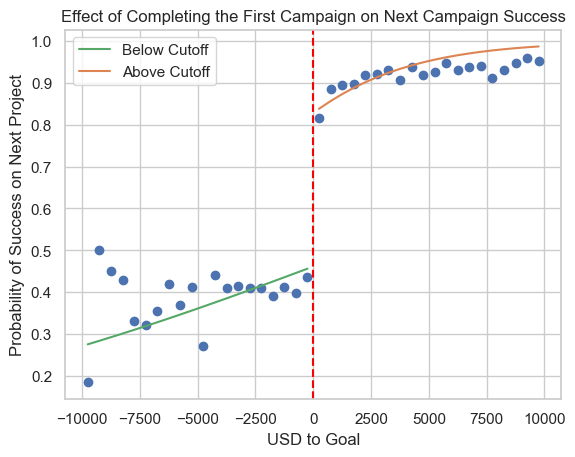

In [102]:
# Remove outliers
plt.figure()
plt.scatter(plotting_df['dollars_to_goal'], plotting_df['success_next'], color = "C0")
#ax = plotting_df.plot.scatter(x = 'dollars_to_goal', y = 'success_next', color = "C0")

# Create threshold and Interaction Variable
cutoff = 0
plotting_df['threshold'] = 0
plotting_df.loc[plotting_df['dollars_to_goal'] > cutoff, 'threshold'] = 1

# Convert threshold to int
plotting_df['threshold'] = plotting_df['threshold'].astype(int)
plotting_df['dollars_to_goal*threshold'] = plotting_df['dollars_to_goal'] * plotting_df['threshold']

exog_dict = plotting_df[['dollars_to_goal', 'threshold', 'dollars_to_goal*threshold']]
plotting_df['predictions'] = model.predict_proba(exog_dict)[:,1]
left_plotting_df = plotting_df[plotting_df['dollars_to_goal'] < cutoff]
right_plotting_df = plotting_df[plotting_df['dollars_to_goal'] >= cutoff]
plt.plot(left_plotting_df['dollars_to_goal'], left_plotting_df['predictions'], color = 'C2', label = 'Below Cutoff')
plt.plot(right_plotting_df['dollars_to_goal'], right_plotting_df['predictions'], color = 'C1', label = 'Above Cutoff')
plt.legend()
plt.axvline(x = 1, color = 'red', linestyle = '--')
plt.ylabel('Probability of Success on Next Project')
plt.xlabel('USD to Goal')
plt.title('Effect of Completing the First Campaign on Next Campaign Success')

plt.savefig('../images/next_kickstarter/effect_of_completing_the_first_campaign_on_next_campaign_success_with_kernel.png')
plt.show()


## RD with Controls and Weights

In [130]:
weights = Kernels.triangular_kernel(df['dollars_to_goal'], c = cutoff, h = bandwidth)
weights[weights == 0] = 1e-10

all_categories = sorted(df['category_name'].unique())

model = smf.glm('success_next ~ dollars_to_goal + threshold + dollars_to_goal*threshold + goal + backers_count + staff_pick + prelaunch_activated + C(category_name, levels=all_categories)', 
                family = sm.families.Binomial(), 
                data = df, 
                freq_weights = weights).fit()

model.summary().tables[1]


c:\Users\d0tam\kickstarter-JMP\.venv\Lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
c:\Users\d0tam\kickstarter-JMP\.venv\Lib\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
c:\Users\d0tam\kickstarter-JMP\.venv\Lib\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.5712,0.354,-1.613,0.107,-1.265,0.123
"C(category_name, levels=all_categories)[T.Academic]",-0.3653,0.464,-0.788,0.431,-1.274,0.544
"C(category_name, levels=all_categories)[T.Accessories]",1.6191,0.469,3.453,0.001,0.700,2.538
"C(category_name, levels=all_categories)[T.Action]",-0.9717,0.534,-1.818,0.069,-2.019,0.076
"C(category_name, levels=all_categories)[T.Animals]",-0.2365,0.689,-0.343,0.731,-1.586,1.113
"C(category_name, levels=all_categories)[T.Animation]",-0.3956,0.417,-0.948,0.343,-1.214,0.423
"C(category_name, levels=all_categories)[T.Anthologies]",1.5184,0.422,3.597,0.000,0.691,2.346
"C(category_name, levels=all_categories)[T.Apparel]",0.3378,0.440,0.768,0.442,-0.524,1.199
"C(category_name, levels=all_categories)[T.Apps]",-1.0074,0.573,-1.758,0.079,-2.131,0.116
"C(category_name, levels=all_categories)[T.Architecture]",0.1733,0.595,0.291,0.771,-0.993,1.340


## RD with Quadratic

In [104]:
table_model = smf.glm('success_next ~ dollars_to_goal + dollars_to_goal_2 + threshold + dollars_to_goal*threshold + dollars_to_goal_2*threshold', 
                family = sm.families.Binomial(), 
                data = df
                ).fit()

table_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           success_next   No. Observations:                45300
Model:                            GLM   Df Residuals:                    45296
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20313.
Date:                Thu, 05 Dec 2024   Deviance:                       40626.
Time:                        13:18:07   Pearson chi2:                 4.73e+14
No. Iterations:                    40   Pseudo R-squ. (CS):             0.2853
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -0.6111      0.018    -34.844      0.000      -0.645      -0.577
dollars_to_goal              1.795e-06   2.43e-07      7.380      0.000    1.32e-06    2.27e-06
dollars_to_goal_2            1.166e-14   1.62e-15      7.198      0.000    8.48e-15    1.48e-14
threshold                       2.5914      0.026     97.791      0.000       2.540       2.643
dollars_to_goal:threshold     8.74e-06   1.06e-06      8.222      0.000    6.66e-06    1.08e-05
dollars_to_goal_2:threshold -1.046e-12   1.07e-13     -9.794      0.000   -1.26e-12   -8.37e-13
===============================================================================================
"""

## RD with IK and CCT Bandwidth

In [118]:
from rdd import rdd

In [122]:
ik_bandwidth = rdd.optimal_bandwidth(X = ml_df['dollars_to_goal'], Y = ml_df['success_next'], cut = 0)
print(f"Imbens-Kalyanaraman Optimal Bandwidth: {ik_bandwidth:.2f}")

Imbens-Kalyanaraman Optimal Bandwidth: 14.18


In [126]:
bandwidth_data = rdd.truncated_data(df, xname = 'dollars_to_goal', bandwidth=ik_bandwidth, yname = 'success_next', cut = 0)

# Print data shape based on dollars_to_goal variable less than 0 and greater than or equal to 0
print(f"Data Shape: {bandwidth_data.shape}")
print(f"Before Cutoff Data Shape: {bandwidth_data[bandwidth_data['dollars_to_goal'] < 0].shape}")
print(f"After Cutoff Data Shape: {bandwidth_data[bandwidth_data['dollars_to_goal'] >= 0].shape}")



Data Shape: (10596, 153)
Before Cutoff Data Shape: (182, 153)
After Cutoff Data Shape: (10414, 153)


# CATE

## Conditional on Next Goal Intensity

Generate Intensity

In [ ]:
# Create new column for ratio of new goal to first goal
df['new_goal/old_goal'] = df['usd_goal_next'] / df['usd_goal']

# Create new column for intensity where intensity is low if it new_goal/old_goal is between 0 and 0.5, medium low if it is between 0.5 and 0.75, same if it is between 0.75 and 1.25, and high if it is greater than 1.25 
df['intensity'] = 'low'
df.loc[(df['new_goal/old_goal'] >= 0.25) & (df['new_goal/old_goal'] < 0.5), 'intensity'] = 'medium low'
df.loc[(df['new_goal/old_goal'] >= 0.50) & (df['new_goal/old_goal'] < 0.75), 'intensity'] = 'medium'
df.loc[(df['new_goal/old_goal'] >= 0.75) & (df['new_goal/old_goal'] < 1), 'intensity'] = 'average'
df.loc[df['new_goal/old_goal'] == 1, 'intensity'] = 'same'
df.loc[(df['new_goal/old_goal'] > 1) & (df['new_goal/old_goal'] < 1.25), 'intensity'] = 'above average'
df.loc[(df['new_goal/old_goal'] >= 1.25) & (df['new_goal/old_goal'] < 1.5), 'intensity'] = 'high'
df.loc[(df['new_goal/old_goal'] >= 1.5) & (df['new_goal/old_goal'] < 2), 'intensity'] = 'very high'
df.loc[df['new_goal/old_goal'] >= 2, 'intensity'] = 'extremely high'



In [ ]:
df['new_goal/old_goal'].describe()

In [ ]:
# Drop rows where success_next is NA
plot_intensity = df.dropna(subset=['success_next'])

# Ensure 'intensity' is a categorical column with a specified order
intensity_order = ['low', 'medium low', 'medium', 'average', 'same', 
                   'above average', 'high', 'very high', 'extremely high']
plot_intensity['intensity'] = pd.Categorical(plot_intensity['intensity'], categories=intensity_order, ordered=True)

# Plot using sns.barplot
plt.figure(figsize=(12, 6))
sns.countplot(data=plot_intensity, 
              x='intensity', 
              hue='success_next', 
              order=intensity_order)
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.title('Distribution of Intensity by Success Next')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility, if needed
plt.legend(title='Success in Next Campaign', loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Create subplots
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

# Flatten the axes array for easier indexing
ax = ax.flatten()

# Iterate through unique intensities and create models
for idx, i in enumerate(df['intensity'].unique()):
    # Ensure you don't exceed subplot limits
    if idx >= len(ax):
        print("Warning: More intensities than subplots available.")
        break

    intensity_df = df[df['intensity'] == i]
    plotting_df = intensity_df[(intensity_df['dollars_to_goal'] <= bandwidth) & (intensity_df['dollars_to_goal'] >= -bandwidth)]

    # Split data into left and right of the cutoff
    left_df = plotting_df[(plotting_df['state'] == 'failed') & (plotting_df['dollars_to_goal'] < cutoff)]
    right_df = plotting_df[(plotting_df['state'] == 'successful') & (plotting_df['dollars_to_goal'] >= cutoff)]

    # Bin each subset separately
    left_df['dollars_to_goal_binned'] = pd.cut(left_df['dollars_to_goal'], bins=bin_size)
    right_df['dollars_to_goal_binned'] = pd.cut(right_df['dollars_to_goal'], bins=bin_size)

    # Aggregate the binned data for each subset
    left_binned_data = left_df.groupby('dollars_to_goal_binned', observed=False).agg({
        'success_next': 'mean',
        'goal': 'mean',
        'backers_count': 'mean',
        'staff_pick': 'mean',
        'prelaunch_activated': 'mean',
        'dollars_to_goal': 'size'  # Counts the number of observations in each bin
    }).reset_index().rename(columns={'dollars_to_goal': 'n_obs'})
    right_binned_data = right_df.groupby('dollars_to_goal_binned', observed=False).agg({
        'success_next': 'mean',
        'goal': 'mean',
        'backers_count': 'mean',
        'staff_pick': 'mean',
        'prelaunch_activated': 'mean',
        'dollars_to_goal': 'size'  # Counts the number of observations in each bin
    }).reset_index().rename(columns={'dollars_to_goal': 'n_obs'})

    # Add a midpoint for each bin for both left and right data
    left_binned_data['dollars_to_goal'] = left_binned_data['dollars_to_goal_binned'].apply(lambda interval: interval.mid)
    right_binned_data['dollars_to_goal'] = right_binned_data['dollars_to_goal_binned'].apply(lambda interval: interval.mid)

    # Combine the binned data for both sides of the cutoff
    plotting_df = pd.concat([left_binned_data, right_binned_data], ignore_index=True)
    plotting_df['threshold'] = 0
    plotting_df.loc[plotting_df['dollars_to_goal'] > cutoff, 'threshold'] = 1
    # Fit the logistic regression model
    model = smf.logit('success_next ~ dollars_to_goal + threshold + dollars_to_goal*threshold', intensity_df).fit()
    print(f"Intensity: {i}")
    print(model.summary().tables[1])
    print("\n")

    # Plot the data and regression discontinuity
    ax[idx].scatter(plotting_df['dollars_to_goal'], plotting_df['success_next'], color="C0")
    ax[idx].plot(plotting_df['dollars_to_goal'], model.predict(plotting_df), color="C1")

    ax[idx].axvline(x=0, color='red', linestyle='--')
    ax[idx].set_title(f'Intensity: {i}')
    ax[idx].set_xlabel('Dollars to Goal')
    ax[idx].set_ylabel('Success Next')

# Adjust layout
plt.tight_layout()
plt.show()

# Models for Table

In [ ]:
# Create threshold square and cubic and their interactions
df['dollars_to_goal_2'] = df['dollars_to_goal'] ** 2
df['dollars_to_goal_3'] = df['dollars_to_goal'] ** 3
df['dollars_to_goal_2*threshold'] = df['dollars_to_goal_2'] * df['threshold']
df['dollars_to_goal_3*threshold'] = df['dollars_to_goal_3'] * df['threshold']


Formulas

In [ ]:
model1 = ['threshold', 'dollars_to_goal']
model2 = ['threshold', 'dollars_to_goal', 'dollars_to_goal*threshold']
model3 = ['threshold', 'dollars_to_goal', 'dollars_to_goal_2']
model4 = ['threshold', 'dollars_to_goal', 'dollars_to_goal_2', 'dollars_to_goal*threshold', 'dollars_to_goal_2*threshold']


models = [model1, model2, model3, model4]

Model

In [ ]:
for i in models:
    X, y = ml_df[X], ml_df['success_next']
    model = LogisticRegression(fit_intercept=True, verbose = 1).fit(X,y)
    print(f"Model: {i}")
    print(f"Threshold Parameter: {model.coef_[0,1]:.5f}")